In [51]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [52]:
plt.style.use('ggplot')
sns.set_palette("husl")

In [53]:
data_dir = './color'
filepaths = list(glob.glob(os.path.join(data_dir, '*/*.JPG'))) + list(glob.glob(os.path.join(data_dir, '*/*.jpg')))

In [54]:
labels = [os.path.basename(os.path.dirname(fp)) for fp in filepaths]

df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

print(f"Total Gambar: {len(df)}")
print(f"Total Kelas: {df['label'].nunique()}")
display(df.head())

Total Gambar: 108606
Total Kelas: 38


filepath               label
0  ./color\Apple___Apple_scab\00075aa8-d81a-4184-...  Apple___Apple_scab
1  ./color\Apple___Apple_scab\01a66316-0e98-4d3b-...  Apple___Apple_scab
2  ./color\Apple___Apple_scab\01f3deaa-6143-4b6c-...  Apple___Apple_scab
3  ./color\Apple___Apple_scab\0208f4eb-45a4-4399-...  Apple___Apple_scab
4  ./color\Apple___Apple_scab\023123cb-7b69-4c9f-...  Apple___Apple_scab

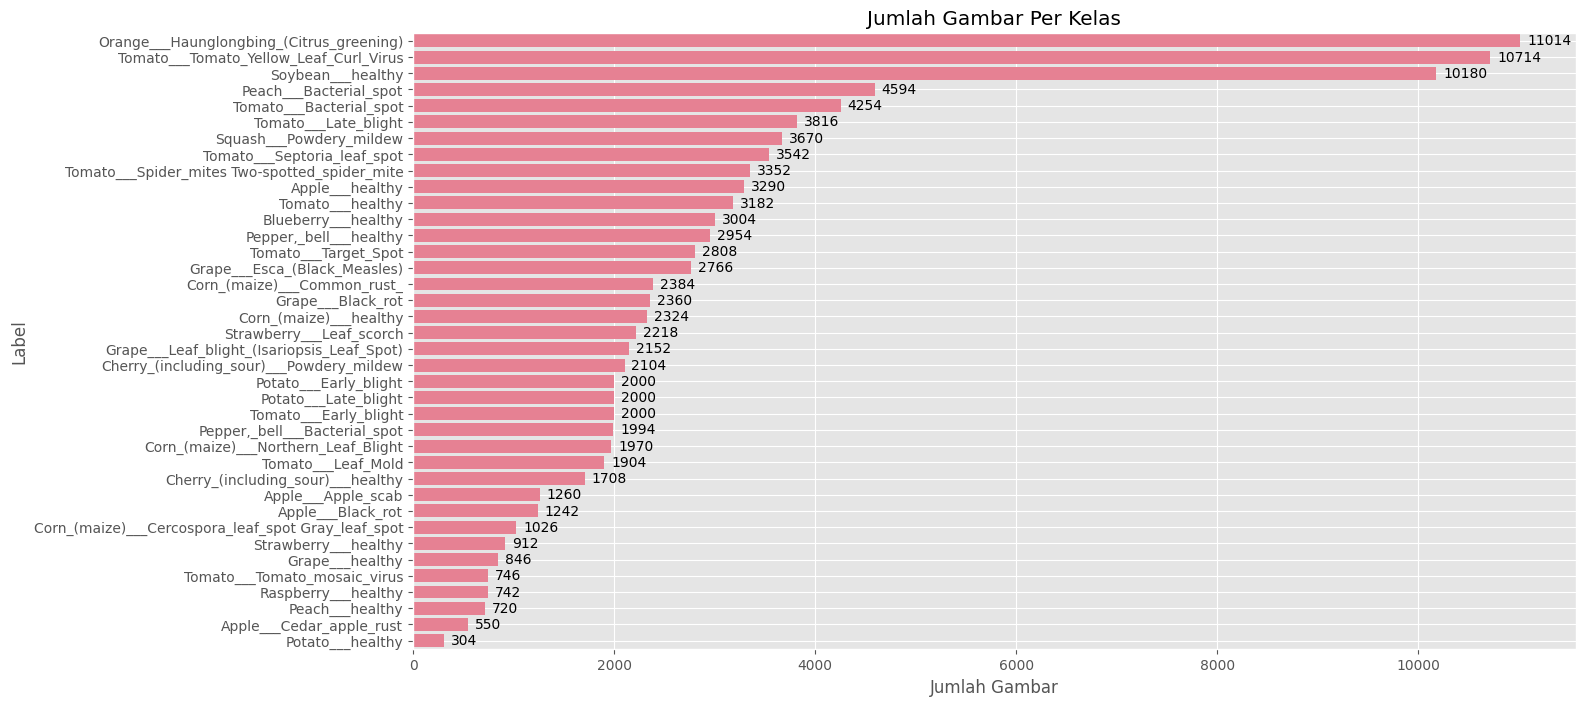

In [55]:
plt.figure(figsize=(15,8))
ax = sns.countplot(y=df['label'], order=df['label'].value_counts().index)

plt.title("Jumlah Gambar Per Kelas")
plt.xlabel("Jumlah Gambar")
plt.ylabel("Label")
plt.grid(axis="y")

for i in ax.containers:
    ax.bar_label(i, padding=5)

plt.show()

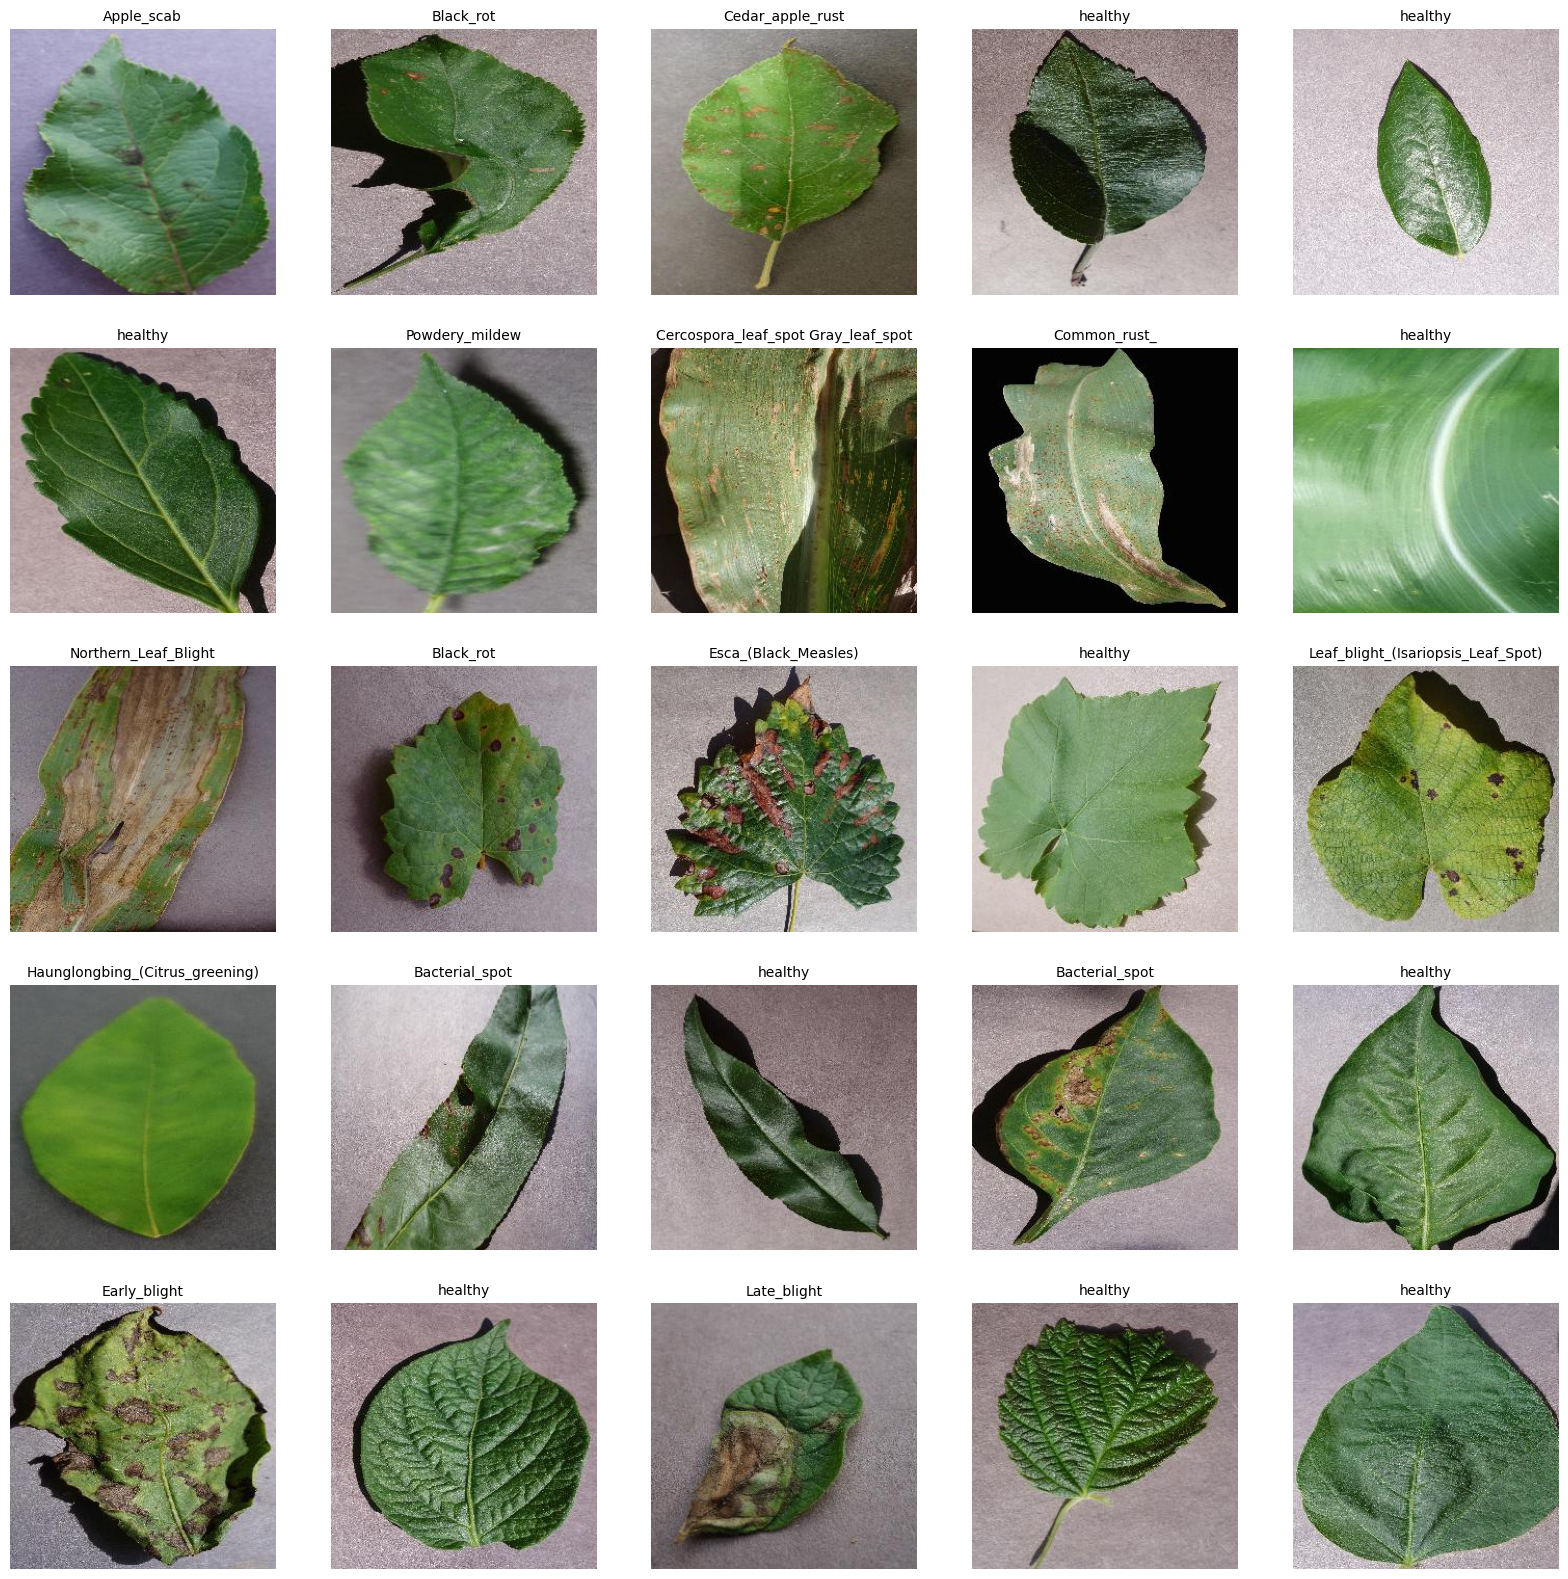

In [56]:
unique_labels = df['label'].unique()[:25]

plt.figure(figsize=(20,20))

for i, label in enumerate(unique_labels):
    img_path = df[df['label'] == label].iloc[0]['filepath']

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(label.split('___')[-1], fontsize=10)
    plt.axis('off')

plt.show()

In [57]:
shapes = []

for fp in df['filepath'].sample(3500, random_state=42):
    img = cv2.imread(fp)
    if img is not None:
        shapes.append(img.shape)

shapes_df = pd.DataFrame(shapes, columns=['Height', 'Width', 'Channel'])

print("Statistik Ukuran Gambar:")
print(shapes_df.describe())

Statistik Ukuran Gambar:
       Height   Width  Channel
count  3500.0  3500.0   3500.0
mean    256.0   256.0      3.0
std       0.0     0.0      0.0
min     256.0   256.0      3.0
25%     256.0   256.0      3.0
50%     256.0   256.0      3.0
75%     256.0   256.0      3.0
max     256.0   256.0      3.0


Bisa dilihat bahwa height, width, dan jumlah channel di image pada dataset sudah sama semua

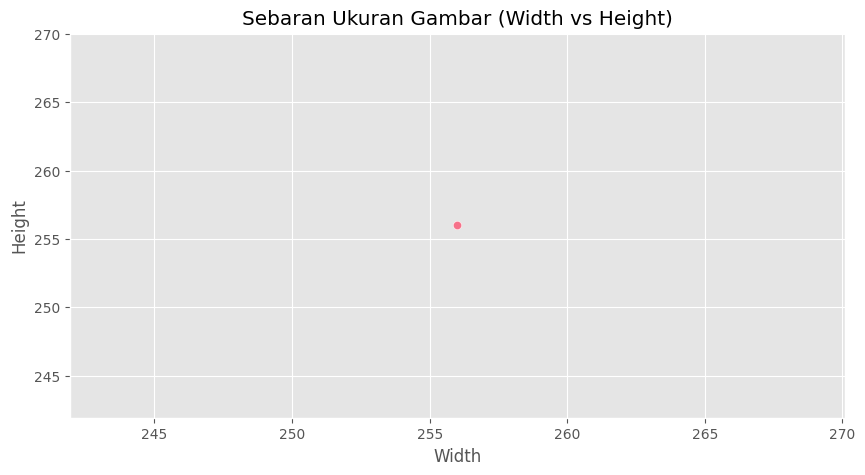

In [58]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Width', y='Height', data=shapes_df, alpha=0.5)
plt.title('Sebaran Ukuran Gambar (Width vs Height)')
plt.show()

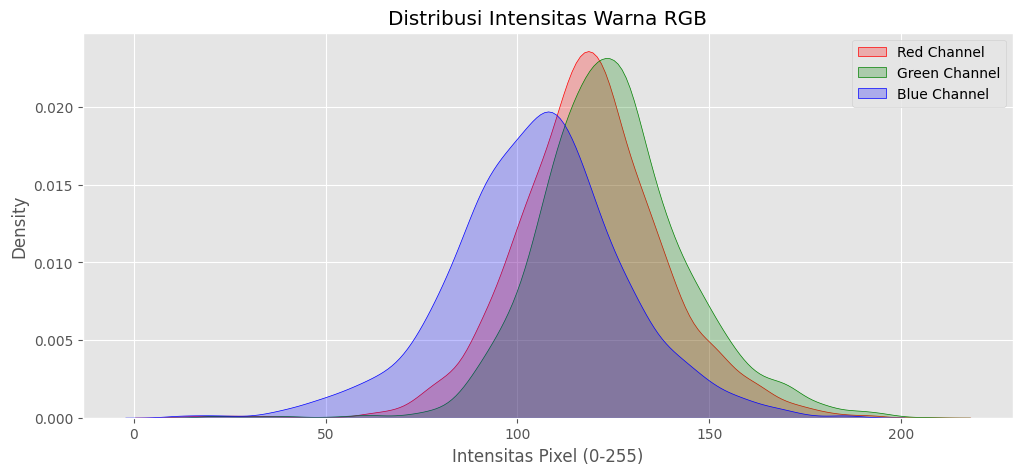

In [59]:
def get_pixel_stats(filepaths):
    red_values = []
    green_values = []
    blue_values = []
    
    for fp in np.random.choice(filepaths, 3500, replace=False):
        img = cv2.imread(fp)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            red_values.append(np.mean(img[:,:,0]))
            green_values.append(np.mean(img[:,:,1]))
            blue_values.append(np.mean(img[:,:,2]))
            
    return red_values, green_values, blue_values

r, g, b = get_pixel_stats(df['filepath'].values)

plt.figure(figsize=(12, 5))
sns.kdeplot(r, color='red', fill=True, label='Red Channel')
sns.kdeplot(g, color='green', fill=True, label='Green Channel')
sns.kdeplot(b, color='blue', fill=True, label='Blue Channel')

plt.title('Distribusi Intensitas Warna RGB')
plt.xlabel('Intensitas Pixel (0-255)')
plt.legend()
plt.show()

Bisa dilihat bahwa didalam dataset red channel berada di posisi tertinggi yang menandakan bahwa mungkin di dataset banyak gambar daun yang sakit dibandingkan dengan sehat karena biasanya daun yang sakit memiliki warna coklat kuning sedangkan daun yang sehat punya warna hijau dominan. 

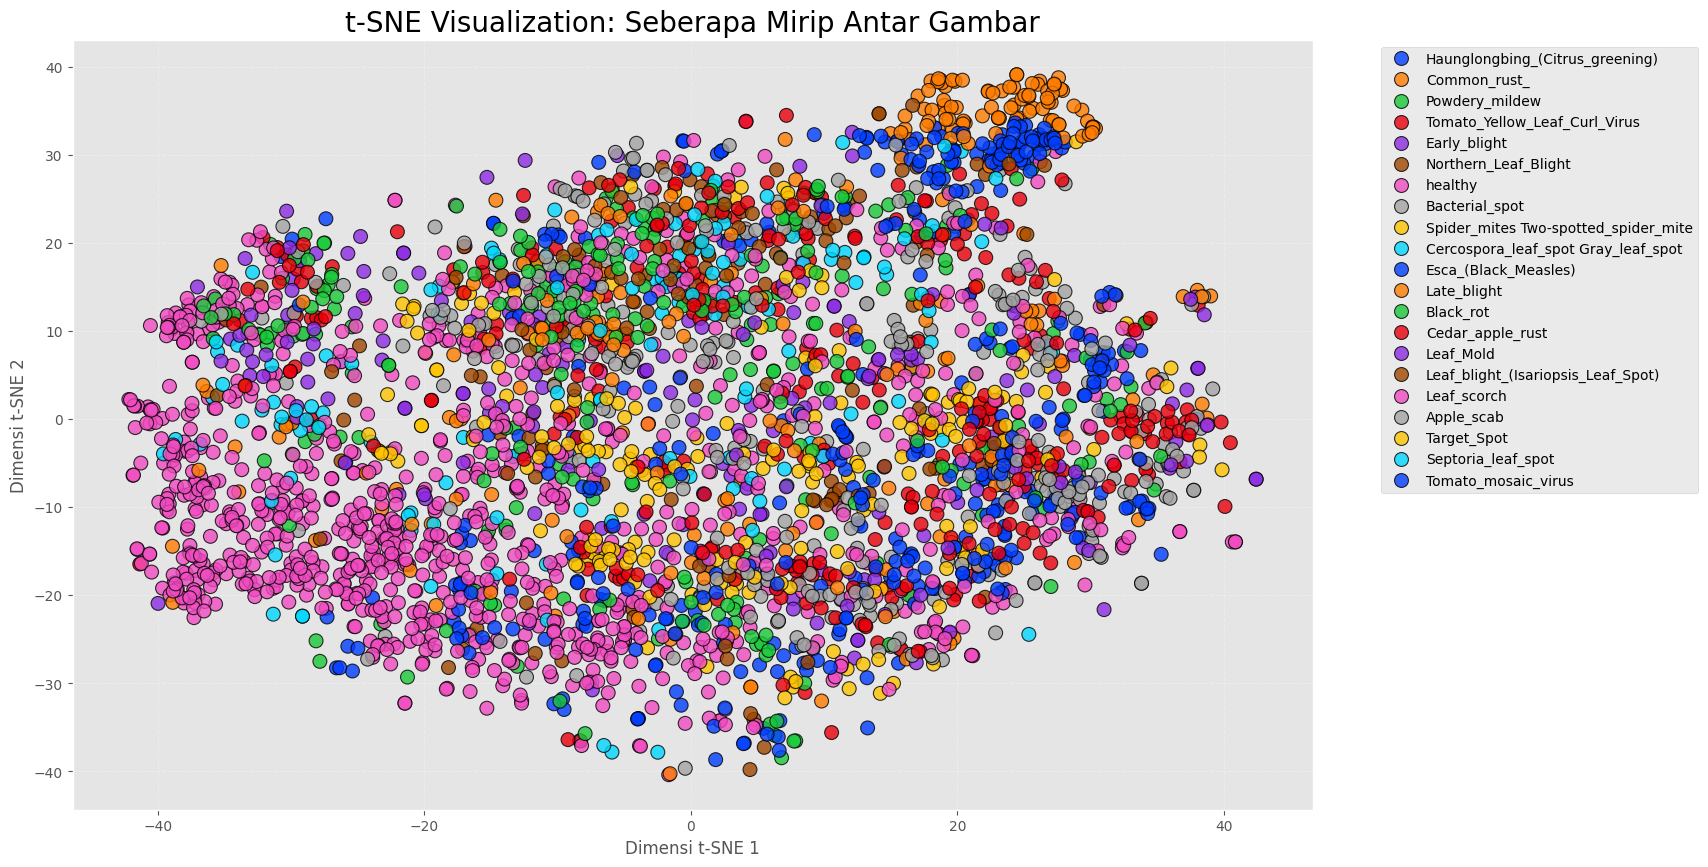

In [60]:
def plot_tsne(df, n_samples=3500):
    sample_df = df.sample(n=min(len(df), n_samples), random_state=42)
    
    images = []
    labels = []
    
    for index, row in sample_df.iterrows():
        img = cv2.imread(row['filepath'])
        if img is not None:
            img = cv2.resize(img, (64, 64)) 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append(img.flatten())
            labels.append(row['label'].split('___')[-1])
            
    X = np.array(images)
    y = np.array(labels)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
    X_tsne = tsne.fit_transform(X_scaled)
    
    plt.figure(figsize=(16, 10))
    sns.scatterplot(
        x=X_tsne[:,0], y=X_tsne[:,1],
        hue=y, palette='bright', s=100, alpha=0.8, edgecolor='black'
    )
    
    plt.title('t-SNE Visualization: Seberapa Mirip Antar Gambar', fontsize=20)
    plt.xlabel('Dimensi t-SNE 1')
    plt.ylabel('Dimensi t-SNE 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

plot_tsne(df)

Bisa dilihat bahwa banyak warna titik titik yang berpencar dan ini menandakan bahwa komputer/model bisa cukup sulit dalam membedakan antara 1 gambar dengan gambar lainnya (kelas-kelasnya mirip secara visual). 